# Testing Amazon's Chronos t5 Model on Inflation Data

### Contents:
1. Loading the Data
2. Setting up the model
3. Inference with the model
4. Storing the forecasts locally
5. Results
6. Evaluation
7. Next Steps

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import time
from scipy.stats import gaussian_kde
import json
import math
import ipywidgets as widgets
from ipywidgets import interact

## 1. Loading the Data

We can download the Consumer Price Index data for the Eurozone from the ECB website.

In [2]:
ind_df = pd.read_csv(
    "HICP_index.csv",
    names = ["date","HICP index"],
    dtype=float,
    header=0,
    index_col=[0],
    date_format="%Y-%m-%d",
    usecols=[0, 2]
)

print(ind_df.head())

            HICP index
date                  
1996-01-31       70.97
1996-02-29       71.29
1996-03-31       71.54
1996-04-30       71.66
1996-05-31       71.83


Now let's compute the quarterly percentual changes to last years values, since it's the standard measure for inflation and it also removes the upward trend in the data, making it better suited for forecasting.

In [3]:
# resample to quarterly data and use the mean of the months' values as the new value
ind_df = ind_df.resample("QE").mean()
# adjust the index of the dataframe to use quarters
ind_df = ind_df.to_period("Q")
# compute the procentual change from last years' data and drop missing values
df = ind_df.pct_change(periods=4).dropna()
df.rename(columns={'HICP index':'HICP rate'}, inplace=True)

print(df.head())

        HICP rate
date             
1997Q1   0.018054
1997Q2   0.013468
1997Q3   0.015865
1997Q4   0.015402
1998Q1   0.011026


(There is data for year-to-year inflation rates available, so technically we don't need to do these transformations manually, this is just for practice/demonstration purposes)

## 2. Setting up the model

In [4]:
from tqdm import tqdm as notebook_tqdm
from chronos import ChronosPipeline

Some parameters to easily change the forecast specifications:

In [5]:
num_samples = 20 # default
# num_samples = 30
# num_samples = 50

model_size = "small"
# model_size = "base"
# model_size = "large"

type_dict={"double": torch.double, "bfloat16": torch.bfloat16}

data_format = "bfloat16"
# data_format = "double"

I downloaded the models beforehand, allowing us to make forecasts without connecting to the internet.

In [6]:
pipeline = ChronosPipeline.from_pretrained(
  f"./chronos_t5_{model_size}",
  # uncomment to forecast on gpu:
  # device_map="cuda", 
  local_files_only=True,
  torch_dtype=type_dict[data_format],
)

## 3. Inference with the model

First, we set up a function that starts and times the inference:

In [7]:
def forecast(pipeline, context, prediction_length, sample_size):
    start_time = time.time()
    forecast = pipeline.predict(context, prediction_length, num_samples=sample_size)
    end_time = time.time()
    runtime = end_time - start_time
    return forecast, runtime  # shape ([num_series, num_samples, prediction_length], runtime)

Standard practice for inflation forecasting is to do forecasts for the remaining quarters of the current and next year. This makes the pipeline a little more complex by introducing varying forecast lengths. For now, the context will be the time series until the forecast time, using a rolling window approach could offer benefits because it would limit structural breaks in the data.

I am working with a 13th Gen Intel(R) Core(TM) i5-1335U 2.50 GHz and 16GB RAM.

In [8]:
# to limit the scope, we can define a quarter where forecasting should start:
# quarter0_date = "2022Q1"
# quarter0 = df.index.get_loc(quarter0_date)

# alternatively, we can choose to forecast from the start (although forecasts without a history of values
#      to base the forecast on are not going to be very good)
quarter0 = 0
quarter0_date = df.index[quarter0]

predictions_low = []
predictions_median = []
predictions_high = []
agg_runtime = 0
predictions = []

for i, date in enumerate(df.index[quarter0:]):
    # we always predict 4 quarters for the next year
    prediction_length = 8 - (i % 4)

    # We create a context input tensor from the data:
    # (the context must be either a 1D tensor, a list of 1D tensors,
    # or a left-padded 2D tensor with batch as the first dimension)
    context = torch.tensor(df.iloc[:quarter0+i]['HICP rate'])

    prediction, runtime = forecast(pipeline, context, prediction_length, num_samples)

    # the prediction is returned as a number of samples from a distribution, so we extract the median and
    #     the 10% and 90% quantiles here already
    low, median, high = np.quantile(prediction[0].numpy(), [0.1, 0.5, 0.9], axis=0)

    # to keep the format consistent, we transform the np.arrays into Python lists while we collect them
    predictions_low.append(low.tolist())
    predictions_median.append(median.tolist())
    predictions_high.append(high.tolist())
        
    agg_runtime += runtime
    predictions.append(prediction.tolist())

print(f"Computed {len(df.index[quarter0:])} predictions in {agg_runtime} seconds")

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_31396\415106006.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context = torch.tensor(df.iloc[:quarter0+i]['HICP rate'])


Computed 111 predictions in 818.6793949604034 seconds


## 4. Storing the forecasts locally

In order to preserve compute resources, we can store the data locally in json files, instead of running the inference again each time.

In [9]:
# Speichern als JSON-Datei
with open(f'./forecasts/forecast_{model_size}_{quarter0_date}_{data_format}_{num_samples}samples.json', 'w') as f:
    json.dump(predictions, f)

with open(f'./forecasts/forecast_{model_size}_{quarter0_date}_median_{data_format}_{num_samples}samples.json', 'w') as f:
    json.dump(predictions_median, f)

with open(f'./forecasts/forecast_{model_size}_{quarter0_date}_low_{data_format}_{num_samples}samples.json', 'w') as f:
    json.dump(predictions_low, f)

with open(f'./forecasts/forecast_{model_size}_{quarter0_date}_high_{data_format}_{num_samples}samples.json', 'w') as f:
    json.dump(predictions_high, f)

# TODO: store runtimes in one excel file instead
with open(f'./forecasts/runtime_{model_size}_{quarter0_date}_{data_format}_{num_samples}samples.txt', 'w') as f:
    f.write(f"Computed {len(df.index[quarter0:])} predictions in {agg_runtime} seconds")

Consistently, we will also want to prepare modifiable code to load our data again from the json files.

In [8]:
m_size= "small"
q0_date = "1997Q1"
d_format="bfloat16"
n_samples=20

with open(f"./forecasts/forecast_{m_size}_{q0_date}_{d_format}_{n_samples}samples.json") as f:
    predictions = json.load(f)

with open(f"./forecasts/forecast_{m_size}_{q0_date}_median_{d_format}_{n_samples}samples.json") as f:
    predictions_median = json.load(f)
    
with open(f"./forecasts/forecast_{m_size}_{q0_date}_high_{d_format}_{n_samples}samples.json") as f:
    predictions_high = json.load(f)

with open(f"./forecasts/forecast_{m_size}_{q0_date}_low_{d_format}_{n_samples}samples.json") as f:
    predictions_low = json.load(f)

## 5. Results

First, let's look at the model performance qualitatively by comparing it's prediction against the measured inflation. We create a function to plot this graph for one year and use ipywidgets to generate an interactive illustration.

In [9]:
# TODO: fix 2024, 2023

def plot_year(year):
    start_year = 1997
    offset = (year-start_year)*4

    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 15)) #, ncols=2)
    for i, ax in enumerate(axes):
        df.plot(label='Actual', ax=ax)
        # mask_actual = (df.index.year == year) & (df.index.quarter == i+1)
        pred_length = len(predictions_median[offset+i])+1

        df_dummy = pd.DataFrame(index = df.iloc[offset+i-1:offset+i+pred_length-1].index,
            data = {
                "prediction" : np.insert(predictions_median[offset+i], 0, df.iloc[offset+i-1]),
                })
        df_dummy.plot(ax=ax, color="tomato")
        ax.fill_between(df_dummy.index,
                         np.insert(predictions_low[offset+i], 0, df.iloc[offset+i-1]),
                         np.insert(predictions_high[offset+i], 0, df.iloc[offset+i-1]),
                                   color="tomato", alpha=0.3, label="80% prediction interval")

        ax.legend()
        ax.grid()

    fig.suptitle(f'{year} Q1 to Q4 forecasts', fontsize=15)
    plt.tight_layout()
    plt.show()

In [10]:
# Create an interactive slider
year_slider = widgets.IntSlider(min=df.index.year.min()+1, max=df.index.year.max(), step=1, value=df.index.year.min(), description='Year')

interact(plot_year, year=year_slider)

interactive(children=(IntSlider(value=1998, description='Year', max=2024, min=1998), Output()), _dom_classes=(…

<function __main__.plot_year(year)>

This interactive graph will not be displayed properly in the GitHub repository preview.

We can also use the function we created to look at specific examples:

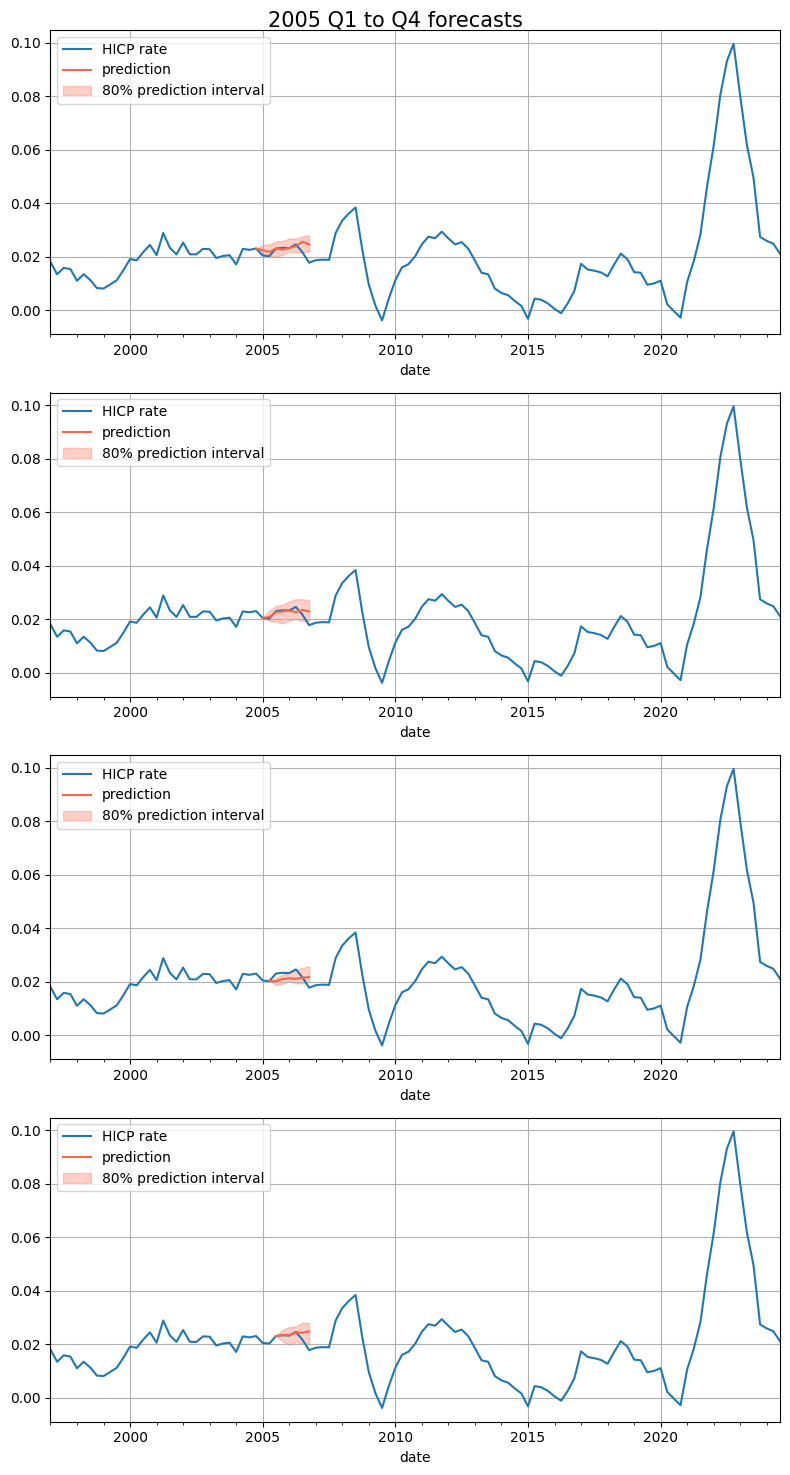

In [11]:
plot_year(2005)

## 6. Evaluation

Usually, to evaluate the models performance on historic data, we would want an accuracy meassure. But as the model returns a set of possible values, as opposed to one guess, we can't just take the prediction error. Therefore we will make use of the idea of perplexity, which is used to evaluate the performance of LLMs. LLMs return a distribution over a vocabulary of words and perplexity looks at the probability of the label (observed data) under this distribution. In our case, we extract the implied non-parametric distribution using kernel density edstimation. For this method, it is recommended to have at least 20 samples for a meaningful distribution, so we are at the lower end with 20 samples per data point. Becuase of the exploding perplexity, I am working with a logarithmic scale and looking at the perplexity curve together with the underlying data already makes qualitative judgements on sdtrengths and weaknesses of the model possible.

The perplexity for a sequence of words can be computed by the formula:

$\LARGE PPL(X) = exp\{-\frac{1}{t} \Sigma_{i=0}^{t}\ log(p_{\theta}(x_i|x_{<i}))\}$

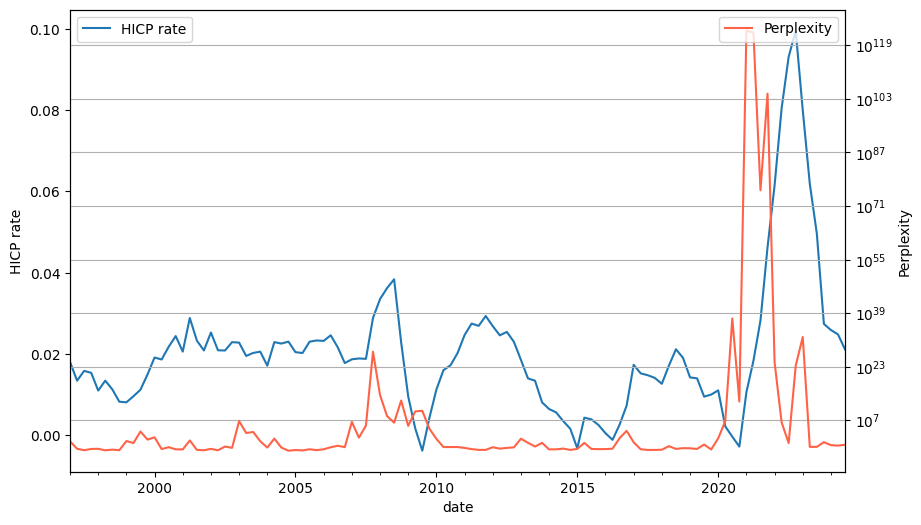

In [13]:
perplexity = []

for i, pred in enumerate(predictions):
    ppl = 0
    pred = pred[0]
    num_q = len(pred[0])
    for j in range(num_q):
        samples = [p[j] for p in pred]
        kde = gaussian_kde(samples, bw_method='scott')
        # corner cases are very much problematic!
        # try and predict in double precision! -> didn't really help
        if i+j < len(df):
            prob = kde.evaluate(df.iloc[i+j])
            # a little scrappy:
            ppl += math.log(prob[0]) if prob != 0 else 0
    ppl /= -num_q # not correct for the last couple of predictions
    ppl = math.exp(ppl)
    perplexity.append(ppl) # if ppl < 10**39 else perplexity.append(1)

df_temp = pd.DataFrame(index = df.index,
                       data = {"Perplexity" : perplexity, "HICP rate" : df["HICP rate"]})

plt.figure(figsize=(10, 6))
ax1 = plt.subplot()
ax2 = ax1.twinx()

l1 = df_temp.plot(
    y=["HICP rate"], ax = ax1, label=["HICP rate"]
    # secondary_y="Perplexity"
    ).legend(loc='upper left')

l2 = df_temp.plot(
    y=["Perplexity"], ax = ax2, color="tomato",  label=["Perplexity"]
    # secondary_y="Perplexity"
    ).legend(loc='upper right')

ax2.set_yscale("log")

ax1.set_ylabel("HICP rate")
ax2.set_ylabel("Perplexity")

plt.grid()
plt.show()

## 7. Next Steps

From here on out, there are different paths to take:
1. Looking at more examples
2. Comparing to state of the art forecasts (like the ecb staff predicitions)
3. Improving the models performance by adjusting context length, sample size, model size
4. Train hyperparameters automatically as in the AutoGluon guide (https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-chronos.html)
5. in-detail validation and testing

There is also a couple of issues to be fixed asap:
1. slider in the result section does not work for 2023 and 2024
2. problems in the evaluation section with vanishing probabilities and exploding perplexity
3. better readability of the results and evaluation sections